<a href="https://colab.research.google.com/github/shinmiura/diveintocode-ml/blob/master/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%95%E3%83%AD%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1.この課題の目的**

・機械学習の実践的な流れを知る

・高い汎化性能を持つモデルを完成させる

**どのように学ぶか**

丁寧な検証が行える状態にした上で、他者の解法を参考に汎化性能の高いモデル作りを進めます。

**2.機械学習フロー**

Kaggleの Home Credit Default Risk コンペティションを題材に、機械学習の実践的な流れを学びます。特に適切な 検証 を行い、高い 汎化性能 のあるモデルを完成させることを目指します。

【問題1】クロスバリデーション

事前学習期間は検証データを分割しておき、それに対して指標値を計算することで検証を行っていました。しかし、分割の仕方により精度は変化します。実践的には クロスバリデーション を行います。


具体的には分割を複数回行い、それぞれに対して学習と検証を行う方法です。複数回の分割を行う関数はscikit-learnにKFoldとして用意されています。

事前学習期間の課題で作成したベースラインモデルに対してKFoldクラスによるクロスバリデーションを行うコードを作成し実行してください。

sklearn.model_selection.KFold — scikit-learn 0.20.2 documentation

In [1]:
#必要なライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
# データの読み込み
dataset = pd.read_csv("/content/drive/MyDrive/DIC/application_train.csv")

In [3]:
# ダミー変数の作成
dataset = pd.get_dummies(dataset)
print(dataset.shape)

(307511, 246)


In [4]:
# 欠損値のある行と列を削除する
dataset = dataset.dropna(how='any', axis=1)
dataset = dataset.dropna(how='any', axis=0)

In [5]:
# ターゲット変数と特徴量を定義する
target_col = 'TARGET'
exclude_cols = ['TARGET', 'SK_ID_CURR']
feature_cols = []
for col in dataset.columns:
  if col not in exclude_cols:
    feature_cols.append(col)

In [6]:
y = dataset[target_col]
X = dataset[feature_cols]

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
#  モデルのライブラリを読み込み
from sklearn.ensemble import RandomForestClassifier

In [9]:
# モデルを使って学習　(RandomForest)
rf = RandomForestClassifier()

In [10]:
# クロスバリデーションとグリッドサーチのライブラリをインポート
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [11]:
# クロスバリデーションの実行
scores = cross_val_score(rf, X=X, y=y, scoring='roc_auc', cv=5)  # データを何分割にして検証するか指定

In [12]:
# 結果の表示
print('Cross validation scores : {}'.format(scores))
print('Cross validation scores : {:.3f}+-{:.3f}'.format(scores.mean(), scores.std()))

Cross validation scores : [0.64070483 0.6364423  0.63083584 0.63512257 0.63694565]
Cross validation scores : 0.636+-0.003


In [13]:
# Kfoldライブラリの読み込み
from sklearn.model_selection import KFold

In [14]:
from sklearn.metrics import log_loss, accuracy_score

In [15]:
# 各foldのスコアを保存するリスト
scores_accuracy = []
scores_logloss = []
# クロスバリデーションを行う
# 学習データを５つに分割し、うち１つをバリデーションデータとすることを、データを変えて繰り返す
kf = KFold(n_splits = 5, random_state = 1234)
rf2 = RandomForestClassifier()
for tr_idx, va_idx in kf.split(X):
  tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
  tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]

  # 　モデルの学習の実行
  rf2.fit(tr_x, tr_y)
  
  # バリデーションデータの予測値を確率で出力
  va_pred = rf2.predict_proba(va_x)[:, 1]
  
  # バリデーションデータでのスコアの計算
  logloss = log_loss(va_y, va_pred)
  accuracy = accuracy_score(va_y, va_pred > 0.5)
  
  # そのfoldスコアを保存
  scores_logloss.append(logloss)
  scores_accuracy.append(accuracy)

# 各foldのスコアの平均を出力する
logloss = np.mean(scores_logloss)
accuracy = np.mean(scores_accuracy)
print(f'logloss: {logloss:.4f}, accuracy: {accuracy:.4f}')

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


logloss: 0.2872, accuracy: 0.9193


【問題2】グリッドサーチ

これまで分類器のパラメータは基本的にデフォルトの設定を使用していました。パラメータの詳細は今後のSprintで学んでいくことになりますが、パラメータは状況に応じて最適なものを選ぶ必要があります。パラメータを探索するために グリッドサーチ と呼ばれる総当たり的手法が一般的に利用されます。


グリッドサーチをパイプラインの中に組み込みましょう。

In [16]:
params = {'n_estimators':[15, 30], 'max_depth':[10, 30]}
gscv = GridSearchCV(rf, param_grid = params, verbose = 1, cv = 5, scoring='roc_auc')
gscv.fit(X, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  5.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [17]:
# 最も平均精度が良いハイパーパラメータの組み合わせを確認
gscv.best_params_

{'max_depth': 10, 'n_estimators': 30}

In [18]:
# ROC、AUC計算と混同行列作成のためのライブラリ読み込み
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [19]:
# 各foldのスコアを保存するリスト
scores_accuracy3= []

# 上記の最適だったパラメータの組み合わせでモデル評価を実施
for tr_idx, va_idx in kf.split(X):
  tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
  tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]
  rf3 = RandomForestClassifier(max_depth = 10, n_estimators = 30, random_state = 1234)
  rf3.fit(tr_x, tr_y)
  
  # バリデーションデータの予測値を確率で出力
  va_pred3 = rf3.predict_proba(va_x)[:, 1]
  
  # バリデーションデータでのスコアの計算
  accuracy3 = accuracy_score(va_y, va_pred3 > 0.5)
  
  # そのfoldスコアを保存
  scores_accuracy3.append(accuracy3)

# 各foldのスコアの平均を出力する
accuracy3 = np.mean(scores_accuracy3)
print(f'accuracy3: {accuracy3:.4f}')

accuracy3: 0.9193


【問題3】Kaggle Notebooksからの調査

KaggleのNotebooksから自身にはなかったアイデアを見つけ出して、列挙してください。


〈自身にはなかったアイデア〉

●カテゴリデータの各列におけるユニークなエントリーの数を数を確認していた。
その結果、ほとんどのカテゴリー変数は、ユニークなエントリの数が比較的少なかったため、それらのカテゴリー変数を処理する方法を探すというアプローチをとっていた。

●one-hot encodingの唯一の欠点が、多くのカテゴリーを持つカテゴリー変数では、特徴（データの次元）の数が爆発的に増加する可能性があることであるため、当該問題に対処すべくone-hot encodingを行った後に、PCAなどの次元削減手法を用いて、次元数を減らすことができる（ただし、情報の保持には注意が必要です）旨を紹介していた。

●異常値の重要性の有無を確認していた。その上で、重要性があったため実際にこれらの値を埋めたかどうかを機械学習モデルに伝えるという明確な意志を持って処理していた。具体的な解決策として、異常値をnot a number (np.nan)で埋め、その値が異常値かどうかを示すブール値の列を新たに作成していた。trainデータにそのような処理をしたらtestデータにも同様にnp.nanで埋めていた。

●.corrデータフレーム法を使って、すべての変数とターゲットの間のピアソン相関係数を計算していた。

●年齢がターゲットに与える影響を可視化するために、ターゲットの値ごとに色分けしたカーネル密度推定図（KDE）を作成していた。

●年齢層ごとのFailure to Repay(%)を算出していた。

●新しい変数を用意し、そのいくつかは元の特徴よりもターゲットとの相関が大きくなっていたため、機械学習モデルを構築する際には、これらの特徴を使用した場合と使用しない場合を試し、実際にモデルの学習に役立つかどうかを判断する方法を採っていた。

●例えば、CREDIT_INCOME_PERCENT：顧客の収入に対する与信額の割合、ANNUITY_INCOME_PERCENT: 顧客の収入に対するローンの年金額の割合、などの新たな特徴量を作っていた。

●ランダムフォレストに100本の木を使用すると強力なモデルになるということで木の数=100本に設定していた。自分の場合は、処理時間が長くなりそうなので、最初から木の数が多くなりすぎないことを前提としてしまっていた。

●feature_importanceというものを用いて各変数の重要性を確かめていた。その結果、最も重要な特徴はEXT_SOURCEとDAYS_BIRTHであると予想していた。


【問題4】高い汎化性能のモデル

問題３で見つけたアイデアと、独自のアイデアを組み合わせ高い汎化性能のモデル作りを進めてください。

その過程として、何を行うことで、クロスバリデーションの結果がどの程度変化したかを表にまとめてください。


上記問題３で見つけたランダムフォレストに100本の木を使用数するアイディアを採用する。
それに独自のアイディアとして、木の深さを10or30としたものを少ない方の10でモデル作成を以下に実施する。

In [20]:
# 各foldのスコアを保存するリスト
scores_accuracy4 = []

# 上記の最適だったパラメータの組み合わせでモデル評価を実施
for tr_idx, va_idx in kf.split(X):
  tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
  tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]
  rf4 = RandomForestClassifier(max_depth = 10, n_estimators = 100, random_state = 1234)
  rf4.fit(tr_x, tr_y)
  
  # バリデーションデータの予測値を確率で出力
  va_pred4 = rf4.predict_proba(va_x)[:, 1]
  
  # バリデーションデータでのスコアの計算
  accuracy4 = accuracy_score(va_y, va_pred4 > 0.5)
  
  # そのfoldスコアを保存
  scores_accuracy4.append(accuracy4)

# 各foldのスコアの平均を出力する
accuracy4 = np.mean(scores_accuracy4)
print(f'accuracy4: {accuracy4:.4f}')

accuracy4: 0.9193


In [21]:
# ROC、AUC計算と混同行列作成のためのライブラリ読み込み
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [22]:
# 混合行列を作成(閾値を変えられるようにdef関数化した)
def get_conf_matrix(threshold, y_pred, y_test):
  """

  """
  y2_pred = (y_pred > threshold).astype(int)
  labels = [0, 1]
  confusion_m = confusion_matrix(y_test, y2_pred, labels = labels)
  confusionm_df = pd.DataFrame(confusion_m, columns = labels, index = labels)
  confusionm_df.rename(columns = {0 : 'predicted_0', 1 : 'predicted_1'}, index = {0 : 'actual_0', 1 : 'actual_1'}, inplace = True)
  return confusionm_df

In [24]:
# 偽陽性率と真陽性率の算出
fpr, tpr, thresholds = roc_curve(va_y, va_pred4)

In [25]:
# AUCの算出
auc = auc(fpr, tpr)

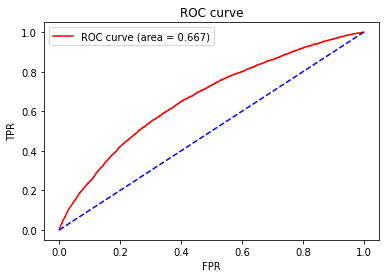

In [26]:
# ROC曲線の描画
plt.plot(fpr, tpr, color = 'red', label = 'ROC curve (area = %.3f)' % auc)
plt.plot([0, 1], [0, 1], color = 'blue', linestyle = '--')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

In [27]:
# テストデータの読み込み
dataset_test = pd.read_csv("/content/drive/MyDrive/DIC/application_test.csv")

In [28]:
dataset_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,...,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,NaN,1,1,0,1,1,0,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,...,0.2446,0.3739,0.0388,0.0817,reg oper account,block of flats,0.3700,Panel,No,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040,-2191,-4000.0,-4262,16.0,1,1,1,1,0,0,NaN,3.0,2,2,FRIDAY,5,0,0,0,0,1,1,Business Entity Type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-821.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
dataset_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


In [30]:
# ダミー変数の作成
dataset_test = pd.get_dummies(dataset_test)
print(dataset_test.shape)

(48744, 242)


In [31]:
# 欠損値のある行と列を削除する
dataset_test = dataset_test.dropna(how='any', axis=1)
dataset_test = dataset_test.dropna(how='any', axis=0)

In [32]:
# ndarrayへの変換(∵scikit-learnはNumPyを想定して作られているが、これまでのデータ分析はPandasのDataFrameを使用してきたため)
X_dataset_test = np.array(dataset_test)
display(X_dataset_test)

array([[1.00001e+05, 0.00000e+00, 1.35000e+05, ..., 0.00000e+00,
        1.00000e+00, 0.00000e+00],
       [1.00005e+05, 0.00000e+00, 9.90000e+04, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00013e+05, 0.00000e+00, 2.02500e+05, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [4.56223e+05, 1.00000e+00, 2.02500e+05, ..., 0.00000e+00,
        1.00000e+00, 0.00000e+00],
       [4.56224e+05, 0.00000e+00, 2.25000e+05, ..., 0.00000e+00,
        1.00000e+00, 0.00000e+00],
       [4.56250e+05, 0.00000e+00, 1.35000e+05, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

In [35]:
# テストデータに対してRandomForestで推定
rf_pred_submission = rf4.predict(X_dataset_test)
print(rf_pred_submission.shape)
print('ランダムフォレストの推定値：{}'.format(rf_pred_submission))

ValueError: ignored

【問題5】最終的なモデルの選定

最終的にこれは良いというモデルを選び、推定した結果をKaggleに提出してスコアを確認してください。どういったアイデアを取り入れ、どの程度のスコアになったかを記載してください。

